In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [5]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = 'C:/Users/CIFAR-10-images-master/train'
TEST_DIR = 'C:/Users/CIFAR-10-images-master/test'

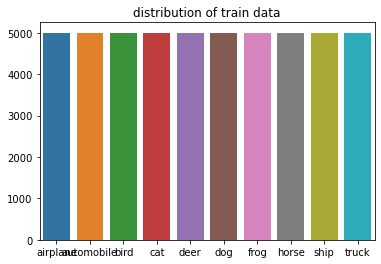

50000


In [6]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)


In [4]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)


In [5]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [6]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [8]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
h = model.fit(
    train_batch,
    steps_per_epoch = 10 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=10 // BATCH_SIZE,
)